<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/Final_project/Larissa_Santesso/entrega_01/CNN_T5_wandb_exp003.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wandb

In [ ]:
!pip install wandb -qqq

In [ ]:
# Log in to your W&B account
import wandb
wandb.login()

wandb: Currently logged in as: larissa_santesso. Use `wandb login --relogin` to force relogin


True

In [ ]:
config_wandb={
        "learning_rate": 3e-3,
        "batch_size": 30,
        "architecture": "CNN + T5-small",
        "dataset": "MS-COCO 23k",
        "epochs": 50,
        "eval_epochs": 1,
        "max_seq_length": 32,
        "decoder_pretrained_model": "google/t5-efficient-small-dm768",
        "path_save_model":  "/content/gdrive/MyDrive/Colab Notebooks/Projeto/modelos/model_CNN_T5_wandb_exp003.pt",
        "path_save_checkpoints":  "/content/gdrive/MyDrive/Colab Notebooks/Projeto/checkpoints/",
        "checkpoint_folder_name": "checkpoint_CNN_T5_003.tar"

}


run = "003"

run_id = None
# run_id = '33cxkjty'

# Importing Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install sacrebleu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
from matplotlib import pyplot as plt
import math
import random
import numpy as np
import h5py, json
from PIL import Image

import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
import os
import collections
import itertools
import functools
from tqdm.notebook import tqdm

from sacrebleu.metrics import BLEU 

In [ ]:
# Check which GPU we are using
!nvidia-smi

Wed Jun 29 18:05:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
if torch.cuda.is_available(): 
   dev = "cuda:0"
else: 
   dev = "cpu"
device = torch.device(dev)
print('Using {}'.format(device))

Using cuda:0


# Dataset: MS-COCO

## Download do dataset reduzido

In [ ]:
!wget -nc https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TRAIN_IMAGES_coco_5_cap_per_img.hdf5
!wget -nc https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TRAIN_CAPTIONS_coco_5_cap_per_img.json
!wget -nc https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/VAL_IMAGES_coco_5_cap_per_img.hdf5
!wget -nc https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/VAL_CAPTIONS_coco_5_cap_per_img.json
!wget -nc https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TEST_IMAGES_coco_5_cap_per_img.hdf5

--2022-06-29 18:04:27--  https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TRAIN_IMAGES_coco_5_cap_per_img.hdf5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 108.177.98.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4624222304 (4.3G) [application/octet-stream]
Saving to: ‘TRAIN_IMAGES_coco_5_cap_per_img.hdf5’

TRAIN_IMAGES_coco_5 100%[===================>]   4.31G   252MB/s    in 23s     

2022-06-29 18:04:50 (193 MB/s) - ‘TRAIN_IMAGES_coco_5_cap_per_img.hdf5’ saved [4624222304/4624222304]

--2022-06-29 18:04:50--  https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TRAIN_CAPTIONS_coco_5_cap_per_img.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 142.250.99.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connecte

In [ ]:
ls

gdrive/                                 TRAIN_IMAGES_coco_5_cap_per_img.hdf5
sample_data/                            VAL_CAPTIONS_coco_5_cap_per_img.json
TEST_IMAGES_coco_5_cap_per_img.hdf5     VAL_IMAGES_coco_5_cap_per_img.hdf5
TRAIN_CAPTIONS_coco_5_cap_per_img.json


## Download do dataset completo

In [ ]:
from transformers import ViTFeatureExtractor, ViTModel, ViTConfig

In [ ]:
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
feature_extractor.image_mean, feature_extractor.image_std

([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])

Em construção

## Construindo CocoDataset `class`


In [ ]:
class CocoDataset():
    def __init__(self, transform=None, mode_dataset = 'TRAIN'):
        
        self.transform = transform

        self.imgs = h5py.File(str(mode_dataset)+'_IMAGES_coco_5_cap_per_img.hdf5', 'r')
        self.imgs = self.imgs['images']
        self.captions = json.load(open(str(mode_dataset)+'_CAPTIONS_coco_5_cap_per_img.json'))

        assert len(self.imgs) == len(self.captions)

    def __len__(self):  
        return len(self.captions)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        caption = self.captions[idx]

        #if self.random_caption==True:
        #    caption = random.choice(caption) 
        
        if self.transform is not None:
            img = self.transform(np.transpose(np.copy(img), (1, 2, 0)))

        return img, caption

In [ ]:
#transform_train = transforms.Compose([
#    transforms.ToTensor(),         
#    transforms.RandomResizedCrop((224,224)),
#    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])

#transform_val = transforms.Compose([
#    transforms.ToTensor(),         
#    transforms.Resize((224,224)),
#    transforms.CenterCrop((224,224)),
#    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])

transform_train = transforms.Compose([
    transforms.ToTensor(),         
    transforms.RandomResizedCrop((224,224)),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

transform_val = transforms.Compose([
    transforms.ToTensor(),         
    transforms.Resize((224,224)),
    transforms.CenterCrop((224,224)),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

tokenizer = T5Tokenizer.from_pretrained(config_wandb["decoder_pretrained_model"])

train_dataset = CocoDataset(transform = transform_train)
val_dataset = CocoDataset(transform = transform_val, mode_dataset='VAL')
#test_dataset = CocoDataset(tokenizer = tokenizer, transform = transform_img, mode_dataset='TEST') ## não tem captions!!!

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.94k [00:00<?, ?B/s]

In [ ]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unorm = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))

# Modelo


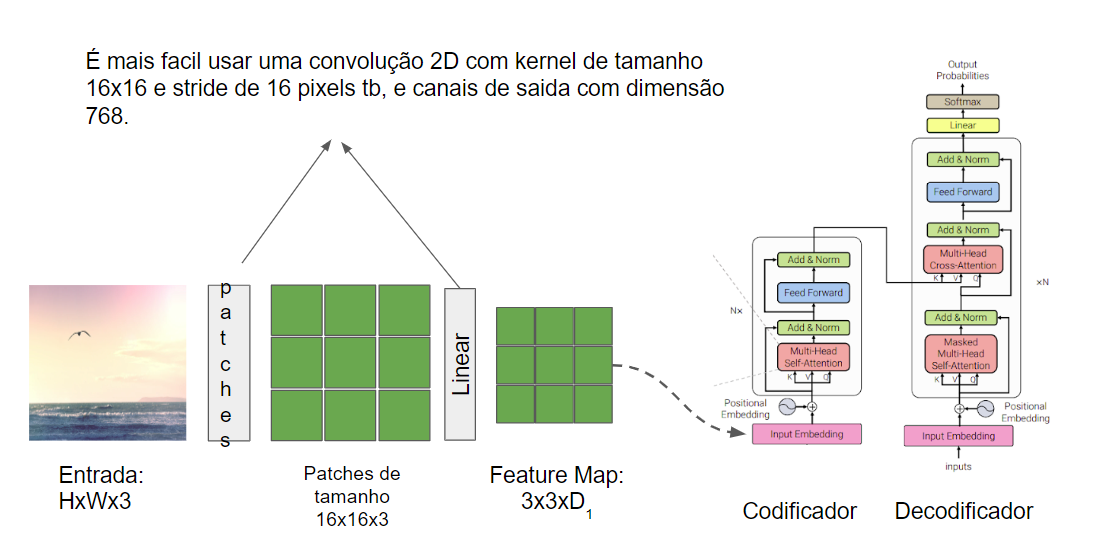

## Decoder T5


https://huggingface.co/docs/transformers/model_doc/t5#transformers.T5ForConditionalGeneration

https://huggingface.co/docs/transformers/v4.19.4/en/main_classes/output#transformers.modeling_outputs.Seq2SeqLMOutput

https://huggingface.co/blog/how-to-generate

In [ ]:
def collate_custom(batch):
    
    imgs = [r[0] for r in batch]
    texts = [r[1] for r in batch] # all captions (5) of each image -- purpose: calculus of NLP metrics
    text = [random.choice(r[1]) for r in batch] # one random caption of each image -- purpose: for training

    batch_tokens = tokenizer.batch_encode_plus(text, return_tensors="pt",  padding='longest')

    return (
        torch.stack(imgs), 
        batch_tokens["input_ids"], 
        texts,
    )

In [ ]:
class CNNT5Model(torch.nn.Module):

    def __init__(self, tokenizer, pretrained_model, max_seq_length=32, img_size = (224,224), patches_size=16, n_channels = 3, input_dimTransformer = 768):
        """
        Implements the CNN + T5 (encoder and decoder)."

        Args:
            tokenizer: tokenizer used for encoding and decoding
            img_size: Size of the input image
            patches_size (int): size of pacthes
            n_channels (int): number of the image channels
            input_dimTransformer (int): input dimension or embedding dimension (d_model) of the transformer
        """
        super(CNNT5Model, self).__init__()

        self.max_seq_length = max_seq_length
        self.pad_token_id = tokenizer.pad_token_id
        self.eos_token_id = tokenizer.eos_token_id
        self.cls_token_id = tokenizer.pad_token_id

        self.img_size = img_size
        self.n_channels = n_channels
        self.embed_size = input_dimTransformer

        # Initializing CNN for creation of patches
        self.cnn_pacthes = nn.Conv2d(self.n_channels, self.embed_size, kernel_size=(patches_size, patches_size), stride=(patches_size, patches_size))
        self.transformer = T5ForConditionalGeneration.from_pretrained(pretrained_model)
        self.transformer.config.eos_token_id = tokenizer.eos_token_id
        self.transformer.config.pad_token_id = tokenizer.pad_token_id
        self.decoder_start_token_id = self.transformer.config.decoder_start_token_id
        # Embedding of the pactches
        self.embeddings_P = nn.Embedding((img_size[0]//patches_size)*(img_size[1]//patches_size)+1, self.embed_size)
        self.cls_token_embed = nn.Embedding(1, self.embed_size)
        #print(self.embeddings_P.weight.shape)
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, images = None, targets = None, decoder_ids = None):
        out_patches = self.cnn_pacthes(images).permute(0, 2, 3, 1) #.view(B,input_dimTransformer,H//patches_size*W//patches_size)
        out_patches  = out_patches.reshape(out_patches.shape[0], -1, self.embed_size)
        #print(out_patches.shape)
        #print(self.cls_token_embed.weight.shape)
                                
        out_patches = torch.cat((self.cls_token_embed.weight.unsqueeze(0).repeat(images.shape[0],1,1), out_patches), dim=1)
        #print(out_patches.shape)
        out_patches+=self.embeddings_P.weight
        out = self.dropout(out_patches)

        if decoder_ids is not None:
            out = self.transformer(inputs_embeds=out, decoder_input_ids=decoder_ids)
        
        # training
        else:
            out = self.transformer(inputs_embeds=out, labels=targets)
            
        return out

In [ ]:
model = CNNT5Model(tokenizer, config_wandb["decoder_pretrained_model"])

In [ ]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Número de parâmetros do modelo: {num_params}')

Número de parâmetros do modelo: 91502336


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=config_wandb["batch_size"], shuffle=True, collate_fn = collate_custom, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=config_wandb["batch_size"], collate_fn = collate_custom, drop_last=True)

for batch, (train_inputs, train_targets, train_all_targets) in enumerate(tqdm(train_loader)):
    model.train()
    model.zero_grad()

    train_inputs = train_inputs.to(device)
    train_targets = train_targets.to(device)

    # para o calculo da loss deve aplicar a máscara no start of sequence também? 
    mylabels = train_targets.clone()
    mylabels[mylabels==tokenizer.pad_token_id] = -100

    train_output = model(images = train_inputs, targets=mylabels)
    logits = train_output.logits
    break

  0%|          | 0/784 [00:00<?, ?it/s]

# Treinamento

Downloading:   0%|          | 0.00/635 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

['A man riding a horse in a grassy area. a man in a grassy area.', 'A man riding a horse in the grass near a car.', 'A man riding a horse in the grass near a car.', 'A man riding a horse in the grass near a car.', 'A man riding a horse in a field. a man riding a snow covered in a field.', 'A man riding a horse in the grass near a car.', 'A man riding a horse in the grass near a car.', 'A man riding a horse in the grass near a tree.', 'A man riding a horse in the snow.. his dog... his mouth..', 'A man riding a horse in a grassy field. a field. a grassy field. a', 'A man riding a horse in a grassy area. a man in a grassy area.', 'A man riding a horse in the grass near a car.', 'A man riding a horse in a field. a man in a field. a man riding a horse.', 'A cat laying on a bed next to a cat.......', 'A cat laying on a bed next to a laptop.......', 'A man riding a horse in a field. a man riding a carriage....', 'A man riding a horse in the grass near a car.', 'A man riding a horse in the gra

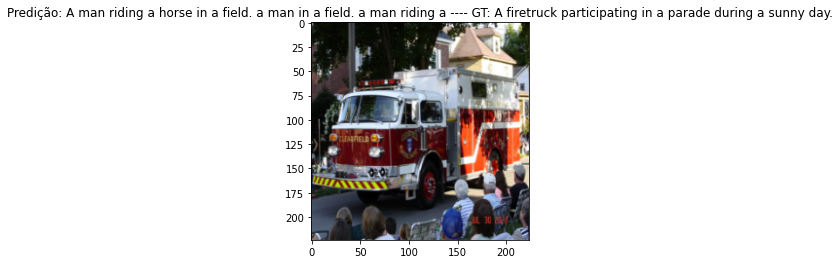

wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Época: 0/49 Train Loss: 2.927355 / Train BLEU: 3.5594605378163897 Valid BLEU: 3.8970041716118797


  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

['A man is holding a hotdog in a bun..........', 'A man is holding a hotdog in a truck.......', 'A large jetliner flying through a blue sky.', 'A man is holding a hotdog in a room.......', 'A man is riding a horse in the middle of the street.', 'A man is riding a horse in the grass.', 'A large jetliner flying in the air. parked on the runway......', 'A man is riding a horse in the grass.', 'A large jetliner flying in the sky. a cloudy sky.', 'A giraffe is standing in the grass near a tree. a tree. a tree. a tree', 'A man is holding a dog in the grass.......', 'A man is riding a horse in the grass.', 'A man is holding a hotdog in a truck.......', 'A man is holding a hotdog in a bun.......', 'A man is holding a hotdog in a living room.', 'A man is holding a hotdog in a bun..........', 'A man is holding a hotdog in a room.......', 'A man is riding a horse in the grass.', 'A man is holding a hotdog in a truck.......', 'A large jetliner flying in the air. parked on the runway.... tarmac..',

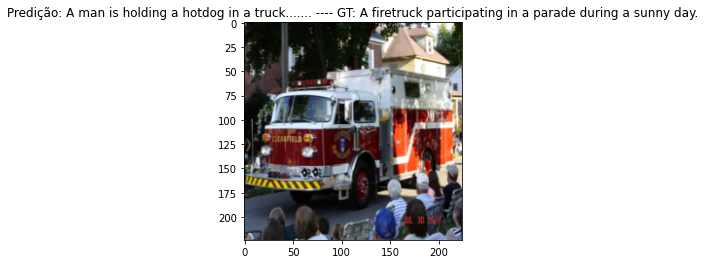

Época: 1/49 Train Loss: 2.792904 / Train BLEU: 4.3745767288930235 Valid BLEU: 3.9034391126997896


  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

['A cat is sitting on top of a laptop computer.', 'A cat is sitting on top of a laptop computer.', 'A dog is sitting on the back of a car.', 'A cat is sitting on top of a laptop computer.', 'A cat is sitting on top of a laptop computer.', 'A cat is sitting on top of a laptop computer.', 'A cat is sitting on top of a laptop computer.', 'A cat is sitting on top of a laptop computer.', 'A cat is sitting on top of a laptop computer.', 'A cat is sitting on top of a laptop computer.', 'A dog is sitting on a bench in the grass.', 'A cat is sitting on top of a laptop computer.', 'A cat is sitting on top of a laptop computer.', 'A cat is sitting on top of a laptop computer.', 'A cat is sitting on top of a laptop computer.', 'A cat is sitting on top of a laptop computer.', 'A cat is sitting on top of a laptop computer.', 'A cat is sitting on top of a laptop computer.', 'A cat is sitting on top of a laptop computer.', 'A cat is sitting on top of a laptop computer.', 'A cat is sitting on top of a 

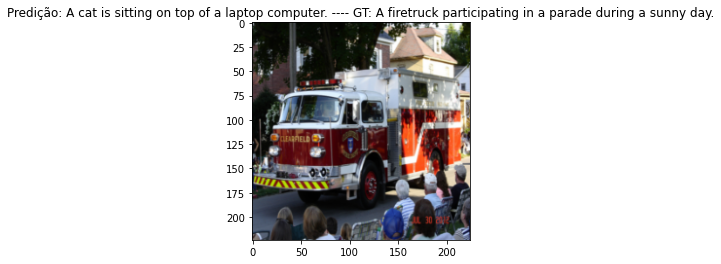

Época: 2/49 Train Loss: 2.734484 / Train BLEU: 4.397482011101843 Valid BLEU: 9.8466337050517


  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

["A cat laying on a bed with a dog. on it's head.. in the background...", 'A cat laying on a bed with a paw on it. on it. on it. on it. on it.', 'A cat laying on a bed with a paw on it. on it. on it. on it. on it.', 'A cat laying on a bed with a hat on it.........', 'A cat laying on a bed with a hat on it.........', 'A cat laying on a bed with a paw on it. on it. on it. on it. on it.', 'A cat laying on a bed with a paw on it. on it. on it. on it. on it.', 'A cat laying on a bed with a paw on it. on it. on it. on it. on it.', 'A cat laying on a bed with a dog on it. in the background.......', "A cat laying on a bed with a dog on it's head.. on it's head.. in the", 'A cat laying on a bed with a paw on it. on it. on it. on it. on it.', 'A cat laying on a bed with a paw on it. on it. on it. on it. on it.', 'A cat laying on a bed with a hat on it.........', 'A cat laying on a bed with a hat on it.........', 'A cat laying on a bed with a hat on it.. on it.. on it...', 'A cat laying on a bed 

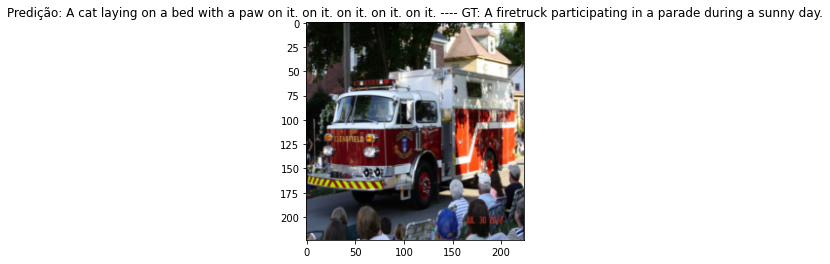

Época: 3/49 Train Loss: 2.712863 / Train BLEU: 4.1903843212232905 Valid BLEU: 2.546477381992341


  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

['A man is sitting on a couch on a couch on a couch on a couch on a couch on a couch on a couch', 'A cat sitting on a couch.............', 'A man is sitting on a couch on a couch on a couch on a couch on a couch on a couch on a couch', 'A man is sitting on a couch on a couch on a couch on a couch on a couch on a couch on a couch', 'A man is sitting on a couch on a couch on a couch on a couch on a couch on a couch on a couch', 'A man is sitting on a couch on a couch on a couch on a couch on a couch on a couch on a couch', 'A man is sitting on a couch on a couch on a couch on a couch on a couch on a couch on a couch', 'A man is sitting on a couch on a couch on a couch on a couch on a couch on a couch on a couch', 'A man is sitting on a couch on a couch on a couch on a couch on a couch on a couch on a couch', 'A man is sitting on a couch on a couch on a couch on a couch on a couch on a couch on a couch', 'A man is sitting on a couch on a couch on a couch on a couch on a couch on a couch o

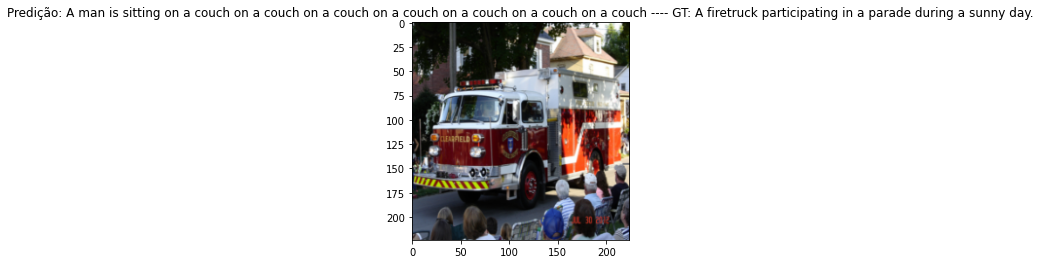

Época: 4/49 Train Loss: 2.808985 / Train BLEU: 3.005397232016155 Valid BLEU: 2.0013218981248784


  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

['A a man a a a a a a a a a a a a a a', 'A a man a a a a a a a a a a a a a a', 'A a man a a a a a a a a a a a a a a', 'A a man a a a a a a a a a a a a a a', 'A a man a a a a a a a a a a a a a a', 'A a man a a a a a a a a a a a a a a', 'A a man a a a a a a a a a a a a a a', 'A a man a a a a a a a a a a a a a a', 'A a man a a a a a a a a a a a a a a', 'A a man a a a a a a a a a a a a a a', 'A a man a a a a a a a a a a a a a a', 'A a man a a a a a a a a a a a a a a', 'A a man a a a a a a a a a a a a a a', 'A a man a a a a a a a a a a a a a a', 'A a man a a a a a a a a a a a a a a', 'A a man a a a a a a a a a a a a a a', 'A a man a a a a a a a a a a a a a a', 'A a man a a a a a a a a a a a a a a', 'A a man a a a a a a a a a a a a a a', 'A a man a a a a a a a a a a a a a a', 'A a man a a a a a a a a a a a a a a', 'A a man a a a a a a a a a a a a a a', 'A a man a a a a a a a a a a a a a a', 'A a man a a a a a a a a a a a a a a', 'A a man a a a a a a a a a a a a a a', 'A a man a a a a a a a a

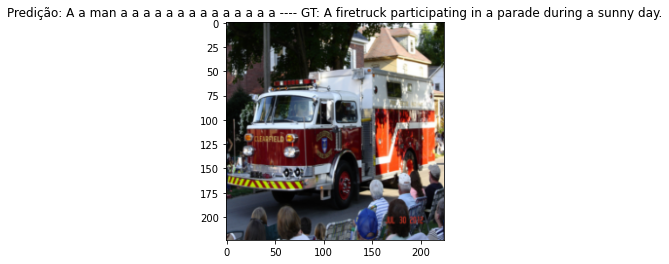

Época: 5/49 Train Loss: 2.930340 / Train BLEU: 2.9846527602978603 Valid BLEU: 0.443365329977835


  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

['A cat is sitting on a laptop....', 'A cat is sitting on a laptop....', 'A cat is sitting on a laptop....', 'A cat is sitting on a laptop....', 'A cat is sitting on a laptop....', 'A cat is sitting on a laptop....', 'A cat is sitting on a laptop....', 'A cat is sitting on a laptop....', 'A man is a horse is a horse on a horse.', 'A cat is sitting on a laptop....', 'A cat is sitting on a laptop....', 'A cat is sitting on a laptop....', 'A cat is sitting on a laptop....', 'A cat is sitting on a laptop....', 'A cat is sitting on a laptop....', 'A cat is sitting on a laptop....', 'A cat is sitting on a laptop....', 'A cat is sitting on a laptop....', 'A cat is sitting on a laptop....', 'A cat is sitting on a laptop....', 'A cat is sitting on a laptop....', 'A cat is sitting on a laptop....', 'A cat is sitting on a laptop....', 'A cat is sitting on a laptop....', 'A cat is sitting on a laptop....', 'A man is a dog is sitting on a bed..', 'A cat is sitting on a laptop....', 'A cat is sittin

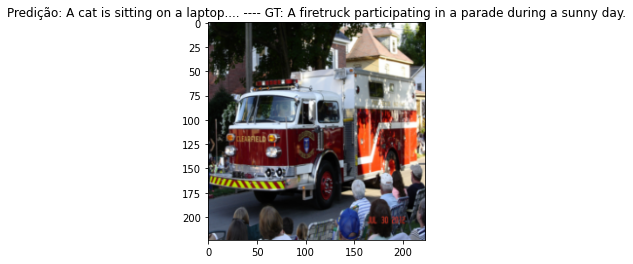

Época: 6/49 Train Loss: 3.052330 / Train BLEU: 2.1625229184517103 Valid BLEU: 4.582446673006157


  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

['A large truck parked on a street. a horse. a street. a street. a street.', 'A man riding a horse a horse a horse a horse a horse a horse a horse a horse a horse a', 'A large truck parked on a street. a horse. a horse. a horse. a horse.', 'A man riding a horse a horse a horse a horse a horse a horse a horse a horse a horse a', 'A large truck parked on a large a large a large a large a large a large a large a large a', 'A large truck down a horse on a horse. a horse. a horse. a horse. a horse.', 'A man riding a horse a horse a horse a horse a horse a horse a horse a horse a horse a', 'A man riding a horse a horse a horse a horse a horse a horse a horse a horse a horse a', 'A large airplane flying through the sky flying over the sky. sky flying over the sky flying over the sky flying over the sky flying over the sky flying over', 'A man riding a horse a horse a horse a horse a horse a horse a horse a horse a horse a', 'A man riding a horse a horse a horse a horse a horse a horse a horse

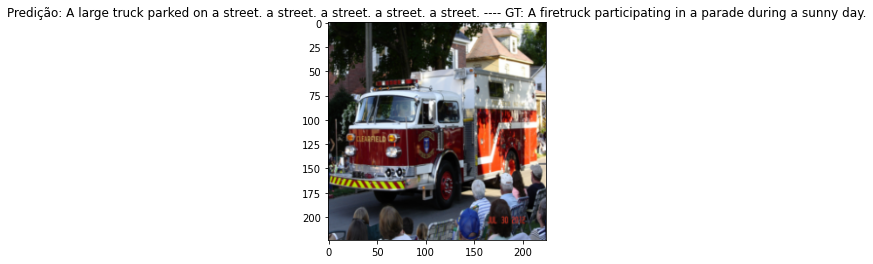

Época: 7/49 Train Loss: 3.140930 / Train BLEU: 2.5849174704233353 Valid BLEU: 1.3678384428617518


  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

['A man is sitting on a a a a a a a a a a a a a', 'A man is sitting on a a a a a a a a a a a a a', 'A man is sitting on a a a a a a a a a a a a a', 'A man is sitting on a a a a a a a a a a a a a', 'A man is sitting on a a a a a a a a a a a a a', 'A man is sitting on a a a a a a a a a a a a a', 'A man is sitting on a a a a a a a a a a a a a', 'A man is sitting on a a a a a a a a a a a a a', 'A man is sitting on a a a a a a a a a a a a a', 'A man is sitting on a a a a a a a a a a a a a', 'A man is sitting on a a a a a a a a a a a a a', 'A man is sitting on a a a a a a a a a a a a a', 'A man is sitting on a a a a a a a a a a a a a', 'A man is sitting on a a a a a a a a a a a a a', 'A man is sitting on a a a a a a a a a a a a a', 'A man is sitting on a a a a a a a a a a a a a', 'A man is sitting on a a a a a a a a a a a a a', 'A man is sitting on a a a a a a a a a a a a a', 'A man is sitting on a a a a a a a a a a a a a', 'A man is sitting on a a a a a a a a a a a a a', 'A man is sitting o

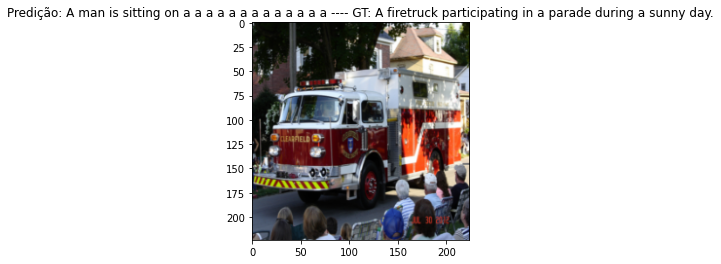

Época: 8/49 Train Loss: 3.235176 / Train BLEU: 2.39084705009318 Valid BLEU: 2.4059590353724576


  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

['A man is a horse.', 'A man is a horse.', 'A man is a horse.', 'A man is a horse.', 'A man is a horse.', 'A man is a horse.', 'A man is a horse.', 'A man is a horse.', 'A man is a horse.', 'A man is a horse.', 'A man is a horse.', 'A man is a horse.', 'A man is a horse.', 'A man is a horse.', 'A man is a horse.', 'A man is a horse.', 'A man is a horse.', 'A man is a horse.', 'A man is a horse.', 'A man is a horse.', 'A man is a horse.', 'A man is a horse.', 'A man is a horse.', 'A man is a horse.', 'A man is a horse.', 'A man is a horse.', 'A man is a horse.', 'A man is a horse.', 'A man is a horse.', 'A man is a horse.']
['A man is a horse. a horse. a horse.', 'A man is a horse. a horse. a horse.', 'A man is a horse. a horse. a horse.', 'A man is a horse. a horse. a horse.', 'A man is a horse. a horse. a horse.', 'A man is a horse. a horse. a horse.', 'A man is a horse. a horse. a horse.', 'A man is a horse. a horse. a horse.', 'A man is a horse. a horse. a horse.', 'A man is a horse

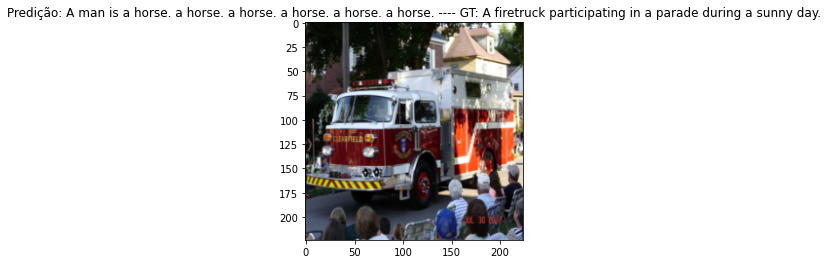

Época: 9/49 Train Loss: 3.294615 / Train BLEU: 2.6132089876383593 Valid BLEU: 1.165342759300277


  0%|          | 0/784 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
# Treinamento
lr = config_wandb["learning_rate"]
compare=float('-inf')
n_epochs = config_wandb["epochs"]


model = CNNT5Model(tokenizer, config_wandb["decoder_pretrained_model"])
model = model.to(device)

#indices = torch.randperm(len(train_dataset))[:500]
#dataset_train = torch.utils.data.Subset(train_dataset, indices)
#train_loader = DataLoader(dataset_train, batch_size=5, shuffle=True, collate_fn = collate_custom, drop_last=True)

train_loader = DataLoader(train_dataset, batch_size=config_wandb["batch_size"], shuffle=True, collate_fn = collate_custom, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=config_wandb["batch_size"], collate_fn = collate_custom, drop_last=True)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# referencia: https://towardsdatascience.com/machine-translation-evaluation-with-sacrebleu-and-bertscore-d7fdb0c47eb3
bleu = BLEU()

train_losses = []
val_losses = []
val_bleu_epoch = []
train_bleu_epoch = []

eval_epochs = 1

# Starting wandb
if run_id is not None:
    print(run_id)
    run = wandb.init(project="Image_Captioning", name=f"experiment_CNN_T5_{run}", config=config_wandb, resume=run_id, id=run_id, settings=wandb.Settings(start_method="thread"), reinit=True, dir=os.getenv("WANDB_DIR", config_wandb["path_save_checkpoints"]))

else:
    epoch_init = 0
    run = wandb.init(project="Image_Captioning", name=f"experiment_CNN_T5_{run}", config=config_wandb, resume=True, settings=wandb.Settings(start_method="thread"), reinit=True, dir=os.getenv("WANDB_DIR", config_wandb["path_save_checkpoints"]))

if wandb.run.resumed:
    print("Wandb --resumed")
    wandb.restore(config_wandb["path_save_checkpoints"]+config_wandb["checkpoint_folder_name"])
    checkpoint = torch.load(config_wandb["path_save_checkpoints"]+config_wandb["checkpoint_folder_name"])
    print(checkpoint['loss'])
    print(checkpoint['epoch'])
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch_init = checkpoint['epoch']+1
    loss = checkpoint['loss']

for epoch in  range(epoch_init, config_wandb["epochs"]):
    bleu_list = []
    for batch, (train_inputs, train_targets, train_all_targets) in enumerate(tqdm(train_loader)):
        model.train()
        model.zero_grad()

        train_inputs = train_inputs.to(device)
        train_targets = train_targets.to(device)

        # para o calculo da loss deve aplicar a máscara no start of sequence também? 
        mylabels = train_targets.clone()
        mylabels[mylabels==tokenizer.pad_token_id] = -100

        train_output = model(images = train_inputs, targets=mylabels)
        logits = train_output.logits
        loss = train_output.loss
        train_preds = torch.argmax(logits, dim=-1)

        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        preds_sentences = tokenizer.batch_decode(train_preds,  skip_special_tokens=True) #returns a list
        bleu_result = bleu.corpus_score(preds_sentences, list(zip(*train_all_targets)))
        bleu_list.append(bleu_result.score)
        
        wandb.log({"train/batch": batch,
                   "train/batch/loss":loss.item(), 
                   "train/batch/bleu_score":bleu_result.score, 
                   "train/batch/bleu_score_p1":bleu_result.precisions[0],
                   "train/batch/bleu_score_p4":bleu_result.precisions[3]})
    
    train_loss = sum(train_losses)/len(train_losses)
    train_bleu = sum(bleu_list)/len(bleu_list)
    

    with torch.no_grad():
        bleu_list = []
        for val_batch, (val_inputs, val_targets, val_all_targets) in enumerate(tqdm(val_loader)):
            val_inputs = val_inputs.to(device)
            #val_targets = val_targets.to(device)

            model.eval()
    
            decoded_ids = torch.full((val_inputs.shape[0], 1),
                            model.decoder_start_token_id,
                            dtype=torch.long).to(val_inputs.device)

            #val_labels = torch.cat([decoded_ids,val_targets[:,:-1]], dim=-1)

            for step in range(config_wandb["max_seq_length"]):
                output_val =  model(images =  val_inputs, decoder_ids= decoded_ids)
                
                #print(f"logits.shape: {output_val.logits.shape}")
                val_logits = output_val.logits
                next_token_logits = val_logits[:, -1, :]
                next_token_id = next_token_logits.argmax(1).unsqueeze(-1)
                decoded_ids = torch.cat([decoded_ids, next_token_id], dim=-1)
                #print(f"decoded_ids batch: {decoded_ids}")

                # Check if output is end of senquence for all batches
                if torch.eq(next_token_id[:, -1], model.eos_token_id).all():
                    break

            #loss_v = nn.functional.cross_entropy(val_logits.contiguous().view(-1, val_logits.shape[-1]), val_labels.view(-1), reduction='mean', ignore_index=0)
            #val_losses.append(loss_v)
            val_preds_sentences = tokenizer.batch_decode(decoded_ids,  skip_special_tokens=True)
            print(val_preds_sentences) 
            bleu_result = bleu.corpus_score(val_preds_sentences, list(zip(*val_all_targets)))
            bleu_list.append(bleu_result.score)

            wandb.log({"val/batch": val_batch,
                    "val/batch/bleu_score":bleu_result.score, 
                    "val/batch/bleu_score_p1":bleu_result.precisions[0],
                    "val/batch/bleu_score_p4":bleu_result.precisions[3]})
            
        #val_loss = sum(val_losses)/len(val_losses)
        val_bleu = sum(bleu_list)/len(bleu_list)

        if val_bleu>compare:
                compare=val_bleu
                torch.save(model, config_wandb["path_save_model"])
    
    if epoch % config_wandb["eval_epochs"] == 0:
        plt.figure()
        plt.imshow(unorm(val_inputs[0].cpu()).permute(1,2,0))
        plt.title("Predição: "+str(val_preds_sentences[0] + " ---- GT: " +str(val_all_targets[0][0])))
        plt.show()
        plt.pause(0.05)

    wandb.log({"epoch": epoch, 
                "train/epoch/loss": train_loss,
                "train/epoch/bleu_score": train_bleu, 
                "val/epoch/bleu_score": val_bleu})

    torch.save({ # Save our checkpoint loc
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        }, config_wandb["path_save_checkpoints"]+config_wandb["checkpoint_folder_name"])
    wandb.save() # saves checkpoint to wandb

    print(f'Época: {epoch:d}/{n_epochs - 1:d} Train Loss: {train_loss:.6f} / Train BLEU: {train_bleu} Valid BLEU: {val_bleu}')

In [ ]:
wandb.finish()

epoch,▁▂▃▃▄▅▆▆▇█
train/batch,▂▃▆█▂▄▇█▃▅▇▂▄▆█▃▅▆▁▄▅▇▂▄▆▁▃▅▇▂▃▆█▂▄▇█▃▅█
train/batch/bleu_score,▅▅▅▇█▄█▄▅▇▄▆▃▇▆▄▆▃▃▄▂▄▁▂▃▂▂▃▁▃▁▃▄▅▄▂▁▅▂▂
train/batch/bleu_score_p1,▃▅▃▆▅▂▅▃▄▄▃▅▃▅▅▃▅▆▆▆▃▇▁▂▅▆▆▅▆▅▆█▇▆▇▆▅▇▇▄
train/batch/bleu_score_p4,▆▄▃▅▇▃█▃▅▆▃▅▂█▄▃▄▂▂▃▁▃▁▂▂▂▂▃▁▂▁▂▂▃▂▂▁▇▂▁
train/batch/loss,▄▄▃▂▂▂▂▂▃▂▃▁▁▂▂▃▃▅▄▅▄▅▄▅▅▆▆▅▆▆█▅▆▅▅▅▆▆█▇
train/epoch/bleu_score,▅██▇▄▄▁▂▂▂
train/epoch/loss,▄▂▁▁▂▄▅▆▇█
val/batch,▂▃▅▇▁▄▅▇▁▃▆▇▁▃▅█▂▃▅▇▂▄▅▇▁▄▆▇▁▃▆█▂▃▅█▂▄▅█
val/batch/bleu_score,▂▄▂▃▄▄▂▂█▆▇▆▂▁▂▂▂▂▁▁▁▁▁▁▃▃▃▃▁▁▁▂▃▂▂▂▁▁▁▂
val/batch/bleu_score_p1,▄▅▅▄▅▅▅▅█▇██▃▃▃▃▂▂▂▂▁▁▁▁▃▇▇▇▁▁▁▁▃▃▃▃▂▂▂▂


# Backup